In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

2025-01-31 21:04:48.186173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-31 21:04:49.098715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-31 21:04:49.396793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 21:04:50.137760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-31 21:04:53.277879: W tensorflow/compiler/tf2

In [77]:
# Define stock ticker and download historical data
ticker = "AAPL"  # Change to any stock
data = yf.download(ticker, start="2015-12-11", end="2024-01-04")

# Selecting only the 'Close' column for prediction
df = data[['Open']].copy()
df.head()

[*********************100%***********************]  1 of 1 completed


/home/chebolu_srikanth/anaconda3/envs/tf/lib/python3.12/site-packages/yfinance/base.py:302:FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/chebolu_srikanth/anaconda3/envs/tf/lib/python3.12/site-packages/yfinance/base.py:303:FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

,Open
Date,
2015-12-10,29.010000
2015-12-11,28.797501
2015-12-14,28.045000
2015-12-15,27.985001
2015-12-16,27.767500


In [78]:
# Normalize the data (Scale values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

# Convert into sequences for LSTM
sequence_length = 60  # Use past 60 days to predict next day's close

X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[i : i + sequence_length])  # Past 60 days as input
    y.append(df_scaled[i + sequence_length])  # Next day's closing price

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Train-test split (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print shape of training and testing data
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (1575, 60, 1), (1575, 1)
Testing data shape: (394, 60, 1), (394, 1)


In [79]:
# Define LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)), 
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50),
    Dropout(0.2),
    
    Dense(units=25),
    Dense(units=1)  # Output layer (Predict next day's closing price)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model Summary
model.summary()


/home/chebolu_srikanth/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204:UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0390 - val_loss: 0.0040
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0

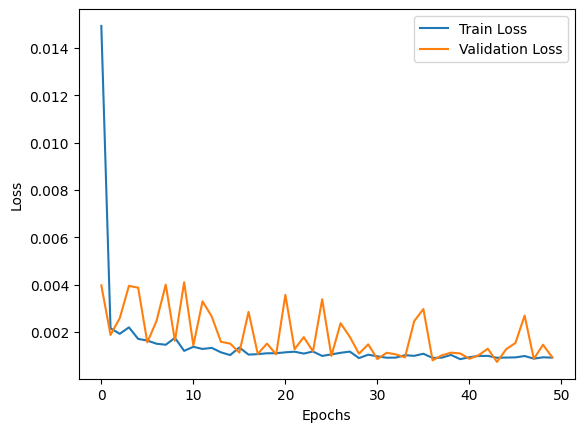

In [80]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Root Mean Squared Error (RMSE): 5.35
Mean Absolute Error (MAE): 4.54


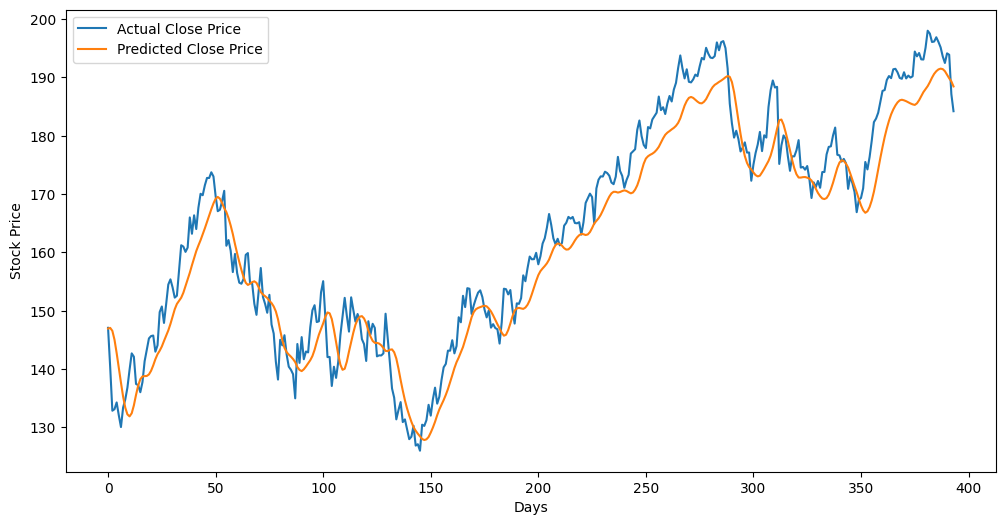

In [81]:
# Make predictions on test set
y_pred_scaled = model.predict(X_test)

# Convert predictions back to original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# Calculate RMSE & MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Plot actual vs predicted closing prices
plt.figure(figsize=(12,6))
plt.plot(y_actual, label="Actual Close Price")
plt.plot(y_pred, label="Predicted Close Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [82]:
# Take last 60 days data for prediction
last_60_days = df_scaled[-sequence_length:].reshape(1, sequence_length, 1)

# Predict the next day's closing price
next_day_scaled = model.predict(last_60_days)
next_day_price = scaler.inverse_transform(next_day_scaled)[0, 0]

print(f"Predicted Closing Price for Next Day: ${next_day_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Closing Price for Next Day: $187.12
